In [1]:
import numpy as np
import ckwrap
from normals_init import find_neighs
from joblib import Parallel, delayed
import os
import torch
from torch_kmeans import KMeans

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
all_pts = np.load("xyz_points.npy")
all_norms = np.load("init_normals.npy")

In [3]:
'''creating patches via clustering'''

def process_one_pcd(pts, norms, main_ind):
    dists_ori, indices_ori = find_neighs(pts)
    neighs = pts[indices_ori]
    print("neighs shape: ", neighs.shape)
    labels_per_row = np.apply_along_axis(lambda row: ckwrap.ckmeans(row, 5).labels, 1, dists_ori)
    print("labels shape: ",labels_per_row.shape)

    pts = torch.from_numpy(pts)
    norms = torch.from_numpy(norms)
    indices_ori = torch.from_numpy(indices_ori)
    labels_per_row = torch.from_numpy(labels_per_row)

    for i,( ind, labels) in enumerate(zip(indices_ori, labels_per_row)):
        center = pts[i]
        print("labels shape:", labels.shape)
        for clus in torch.unique(labels, dim=0):
            # ind_clus = ind[np.where(labels == clus)]
            ind_clus = ind[torch.where(labels==clus)]
            print("ind_clus shape: ",ind_clus.shape)
            coords = pts[ind_clus]
            print("coords shape: ", coords.shape)

            if(coords.shape[0] < 25):
                # 2 random integers
                for i in range(25-(coords.shape[0])):
                    a, b = torch.randint(1, coords.shape[0], (2,))
                    a_n, b_n = torch.divide(a, (a+b)), torch.divide(b, (a+b))
                    rnd_pt = torch.add(torch.multiply(a_n, (center-coords[a])), torch.multiply(b_n, (center-coords[b]))).unsqueeze(0)
                    coords = torch.cat((coords, rnd_pt), dim=0)
            else:
                coords = coords[:25]
            
            print("coords after adding random points: ", coords)

            vec2 = torch.subtract(center,coords)
            print("vec2 : ", vec2)
            print("nearest vec magnitude: ", torch.linalg.norm(vec2, dim=1))
            closest_ind = torch.argmin(torch.linalg.norm(vec2, dim=1))
            closest = coords[closest_ind]
            # vec2 = np.delete(coords, closest_ind, axis=0)
            vec2 = torch.cat((coords[:closest_ind], coords[closest_ind+1:]), dim=0)
            vec1 = torch.subtract(center, closest)
            print(vec1.shape)
            vec1 = torch.divide(vec1, torch.linalg.norm(vec1))
            vec2 = torch.divide(vec2, torch.linalg.norm(vec2, dim=1, keepdim=True))
            print("after norm: ", vec2.shape, vec1.shape)
            print(vec2)
            
            crs_pdts = torch.cross(vec1.expand_as(vec2), vec2) #check done, works as intented
            area = torch.linalg.norm(crs_pdts, dim=1)
            crs_pdts = torch.divide(crs_pdts, torch.linalg.norm(crs_pdts, dim=1, keepdim=True))
            print("crs_pdts after norm shape: ",crs_pdts.shape)
            
            print("shapes for dot: ", crs_pdts.shape, norms[i].shape)
            dot_pdts = torch.tensordot(crs_pdts, norms[i].T, dims=1) #check done, works as intented
            sign = torch.divide(dot_pdts, np.abs(dot_pdts))
            print("dot_pdts shape: ",dot_pdts.shape)
            print("area shape: ",area.shape)
            area = torch.multiply(area, sign)
            sort_indices = torch.argsort(area)
            print("area shape after multi with sign: ",area.shape)
            # area, orient, ind_clus = area[sort_indices], orient[sort_indices], ind_clus[sort_indices]
            # coords_sorted= pts[ind_clus]
            sorted_coords = coords[sort_indices]
            
            return dot_pdts, area, crs_pdts, coords, sorted_coords, vec1, vec2, sign, closest, center
        #     mat.append(sorted_coords)
        # mat = np.array(mat)
        # np.save("patches/pcd_"+str(main_ind)+"/pnt_"+str(i)+".npy", mat)
            # break
        break


dot_pdts, area, crs_pdts, coords, sorted_coords, vec1, vec2, sign, closest, center = process_one_pcd(all_pts[0], all_norms[0], 0)

neighs shape:  (100000, 249, 3)
labels shape:  (100000, 249)
labels shape: torch.Size([249])
ind_clus shape:  torch.Size([23])
coords shape:  torch.Size([23, 3])
coords after adding random points:  tensor([[-1.0000e+00,  9.0934e-02,  1.1721e+01],
        [-1.0000e+00,  1.0145e-01,  1.1705e+01],
        [-1.0000e+00,  1.1260e-01,  1.1715e+01],
        [-1.0000e+00,  7.9621e-02,  1.1731e+01],
        [-1.0000e+00,  7.5980e-02,  1.1725e+01],
        [-1.0000e+00,  8.0252e-02,  1.1704e+01],
        [-1.0000e+00,  1.1485e-01,  1.1709e+01],
        [-1.0000e+00,  9.9300e-02,  1.1695e+01],
        [-1.0000e+00,  1.0221e-01,  1.1688e+01],
        [-1.0000e+00,  7.8690e-02,  1.1748e+01],
        [-1.0000e+00,  6.4145e-02,  1.1736e+01],
        [-1.0000e+00,  8.7351e-02,  1.1753e+01],
        [-1.0000e+00,  5.8686e-02,  1.1715e+01],
        [-1.0000e+00,  8.8460e-02,  1.1756e+01],
        [-1.0000e+00,  6.8877e-02,  1.1747e+01],
        [-1.0000e+00,  6.3158e-02,  1.1694e+01],
        [-1.0000e+

/tmp/ipykernel_155082/104509350.py:57: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  dot_pdts = torch.tensordot(crs_pdts, norms[i].T, dims=1) #check done, works as intented


In [111]:
'''creating patches via clustering'''

def process_one_pcd(pts, norms, main_ind):
    dists_ori, indices_ori = find_neighs(pts)
    print("pts shape: ", pts.shape)
    neighs = pts[indices_ori]
    print("neighs shape: ", neighs.shape)
    labels_per_row = np.apply_along_axis(lambda row: ckwrap.ckmeans(row, 5).labels, 1, dists_ori)
    print("labels shape: ",labels_per_row.shape)

    pts = torch.from_numpy(pts)
    norms = torch.from_numpy(norms)
    indices_ori = torch.from_numpy(indices_ori)
    labels_per_row = torch.from_numpy(labels_per_row)

    for i,( ind, labels) in enumerate(zip(indices_ori, labels_per_row)):
        print(i)
        center = pts[i]
        print("labels shape:", labels.shape)
        for clus in torch.unique(labels, dim=0):
            # ind_clus = ind[np.where(labels == clus)]
            ind_clus = ind[torch.where(labels==clus)]
            print("ind_clus shape: ",ind_clus.shape)
            coords = pts[ind_clus]
            print("coords shape: ", coords.shape)

            if(coords.shape[0] < 25):
                # 2 random integers
                for _ in range(25-(coords.shape[0])):
                    a, b = torch.randint(1, coords.shape[0], (2,))
                    a_n, b_n = torch.divide(a, (a+b)), torch.divide(b, (a+b))
                    rnd_pt = torch.add(torch.multiply(a_n, (center-coords[a])), torch.multiply(b_n, (center-coords[b]))).unsqueeze(0)
                    coords = torch.cat((coords, rnd_pt), dim=0)
            else:
                coords = coords[:25]
            
            # print("coords after adding random points: ", coords)

            
            vec2 = torch.subtract(center, coords)
            print("magnitudes: ", torch.linalg.norm(vec2, dim=1))
            closest_ind = torch.argmin(torch.linalg.norm(vec2, dim=1))
            closest = coords[closest_ind]
            vec1 = torch.subtract(center, closest)
            vec2 = torch.cat((coords[:closest_ind], coords[closest_ind+1:]), dim=0)
            print(vec1, vec2[2,:])
            vec1 = torch.divide(vec1, torch.linalg.norm(vec1))
            vec2 = torch.divide(vec2, torch.linalg.norm(vec2, dim=1, keepdim=True))
            print(vec1, vec2[0,:])
            crs_pdts = torch.cross(vec1.expand_as(vec2), vec2)
            print(crs_pdts[2,:])
            area = torch.linalg.norm(crs_pdts, dim=1)
            crs_pdts = torch.divide(crs_pdts, torch.linalg.norm(crs_pdts, dim=1, keepdim=True))
            print(crs_pdts[2,:])
            print("norms check: ", i, norms[i].shape)
            dot_pdts = torch.tensordot(crs_pdts, norms[i].T, dims=1)
            print(dot_pdts[2])
            sign = torch.divide(dot_pdts, torch.abs(dot_pdts))
            print("dot_pdts shape: ",dot_pdts.shape)
            print("area shape: ",area.shape)
            area = torch.multiply(area, sign)
            sort_indices = torch.argsort(area)
            print("area shape after multi with sign: ",area.shape)
            # area, orient, ind_clus = area[sort_indices], orient[sort_indices], ind_clus[sort_indices]
            # coords_sorted= pts[ind_clus]
            sorted_coords = coords[sort_indices]
            
            return dot_pdts, area, crs_pdts, coords, sorted_coords, vec1, vec2, sign, closest, center
        #     mat.append(sorted_coords)
        # mat = np.array(mat)
        # np.save("patches/pcd_"+str(main_ind)+"/pnt_"+str(i)+".npy", mat)
            # break
        break


dot_pdts, area, crs_pdts, coords, sorted_coords, vec1, vec2, sign, closest, center = process_one_pcd(all_pts[200], all_norms[200], 0)

pts shape:  (100000, 3)
neighs shape:  (100000, 249, 3)
labels shape:  (100000, 249)
0
labels shape: torch.Size([249])
ind_clus shape:  torch.Size([32])
coords shape:  torch.Size([32, 3])
magnitudes:  tensor([0.0255, 0.0258, 0.0293, 0.0394, 0.0456, 0.0463, 0.0497, 0.0502, 0.0507,
        0.0509, 0.0521, 0.0542, 0.0564, 0.0570, 0.0584, 0.0599, 0.0605, 0.0613,
        0.0616, 0.0627, 0.0672, 0.0681, 0.0688, 0.0693, 0.0697],
       dtype=torch.float64)
tensor([ 0.0014, -0.0164,  0.0196], dtype=torch.float64) tensor([ 3.3375, 14.7310, -1.9132], dtype=torch.float64)
tensor([ 0.0555, -0.6408,  0.7657], dtype=torch.float64) tensor([ 0.2182,  0.9677, -0.1259], dtype=torch.float64)
tensor([-0.6603,  0.1748,  0.1941], dtype=torch.float64)
tensor([-0.9299,  0.2462,  0.2734], dtype=torch.float64)
norms check:  0 torch.Size([3])
tensor(-0.9758, dtype=torch.float64)
dot_pdts shape:  torch.Size([24])
area shape:  torch.Size([24])
area shape after multi with sign:  torch.Size([24])


In [99]:
# clean version

'''creating patches via clustering'''

def process_one_pcd(pts, norms, main_ind):
    dists_ori, indices_ori = find_neighs(pts)
    neighs = pts[indices_ori]
    labels_per_row = np.apply_along_axis(lambda row: ckwrap.ckmeans(row, 5).labels, 1, dists_ori)

    pts = torch.from_numpy(pts)
    norms = torch.from_numpy(norms)
    indices_ori = torch.from_numpy(indices_ori)
    labels_per_row = torch.from_numpy(labels_per_row)

    for i,( ind, labels) in enumerate(zip(indices_ori, labels_per_row)):
        center = pts[i]
        for clus in torch.unique(labels, dim=0):
            # ind_clus = ind[np.where(labels == clus)]
            ind_clus = ind[torch.where(labels==clus)]
            coords = pts[ind_clus]

            if(coords.shape[0] < 25):
                # 2 random integers
                for _ in range(25-(coords.shape[0])):
                    a, b = torch.randint(1, coords.shape[0], (2,))
                    a_n, b_n = torch.divide(a, (a+b)), torch.divide(b, (a+b))
                    rnd_pt = torch.add(torch.multiply(a_n, (center-coords[a])), torch.multiply(b_n, (center-coords[b]))).unsqueeze(0)
                    coords = torch.cat((coords, rnd_pt), dim=0)
            else:
                coords = coords[:25]
            
            # print("coords after adding random points: ", coords)

            
            vec2 = torch.subtract(center, coords)
            closest_ind = torch.argmin(torch.linalg.norm(vec2, dim=1))
            closest = coords[closest_ind]
            vec1 = torch.subtract(center, closest)
            vec2 = torch.cat((vec2[:closest_ind], vec2[closest_ind+1:]), dim=0)
            vec1 = torch.divide(vec1, torch.linalg.norm(vec1))
            vec2 = torch.divide(vec2, torch.linalg.norm(vec2, dim=1, keepdim=True))
            crs_pdts = torch.cross(vec1.expand_as(vec2), vec2)
            area = torch.linalg.norm(crs_pdts, dim=1)
            crs_pdts = torch.divide(crs_pdts, torch.linalg.norm(crs_pdts, dim=1, keepdim=True))
            dot_pdts = torch.tensordot(crs_pdts, norms[i].T, dims=1)
            sign = torch.divide(dot_pdts, np.abs(dot_pdts))
            area = torch.multiply(area, sign)
            sort_indices = torch.argsort(area)
            sorted_coords = coords[sort_indices]
            
            return dot_pdts, area, crs_pdts, coords, sorted_coords, vec1, vec2, sign, closest, center, closest_ind
            
        #     mat.append(sorted_coords)
        # mat = np.array(mat)
        # np.save("patches/pcd_"+str(main_ind)+"/pnt_"+str(i)+".npy", mat)
            # break
        break


dot_pdts, area, crs_pdts, coords, sorted_coords, vec1, vec2, sign, closest, center, c_ind = process_one_pcd(all_pts[0], all_norms[0], 0)

In [100]:
area

tensor([ 0.3880, -0.5087,  0.0037,  0.3393,  0.9972, -0.2782,  0.6171,  0.5831,
        -0.3812,  0.1721, -0.6248,  0.7135, -0.6590, -0.1538,  0.9753, -0.6110,
        -0.1234, -0.1888, -0.0167,  0.6025, -0.2462, -0.3392,  0.7738,  0.7770],
       dtype=torch.float64)

In [101]:
sign

tensor([ 1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1., -1., -1.,
         1., -1., -1., -1., -1.,  1., -1., -1.,  1.,  1.], dtype=torch.float64)

In [102]:
dot_pdts

tensor([ 0.9956, -0.9956,  0.9956,  0.9956,  0.9956, -0.9956,  0.9956,  0.9956,
        -0.9956,  0.9956, -0.9956,  0.9956, -0.9956, -0.9956,  0.9956, -0.9956,
        -0.9956, -0.9956, -0.9956,  0.9956, -0.9956, -0.9956,  0.9833,  0.9833],
       dtype=torch.float64)

In [27]:
# print(coords.shape)
# print(closest, all_pts[0][0])

vec1 = torch.subtract(center, closest)
vec2 = torch.subtract(center, coords[2])
print(vec1, vec2)
vec1 = torch.divide(vec1, torch.linalg.norm(vec1))
vec2 = torch.divide(vec2, torch.linalg.norm(vec2))
print(vec1, vec2)
crs = torch.cross(vec1, vec2)
print(crs)
crs = torch.divide(crs, torch.linalg.norm(crs))
print(crs)
dot = torch.dot(crs, torch.tensor(all_norms[0][0]))
print(dot)

tensor([ 0.0000,  0.0035, -0.0029], dtype=torch.float64) tensor([ 0.0000, -0.0182,  0.0030], dtype=torch.float64)
tensor([ 0.0000,  0.7681, -0.6404], dtype=torch.float64) tensor([ 0.0000, -0.9870,  0.1607], dtype=torch.float64)
tensor([-0.5087, -0.0000, -0.0000], dtype=torch.float64)
tensor([-1., -0., -0.], dtype=torch.float64)
tensor(-0.9956, dtype=torch.float64)


In [90]:
# print(vec2_r, vec2)

In [96]:
c_ind

tensor(0)

In [95]:
vec2

tensor([[-0.0851,  0.0086,  0.9963],
        [-0.0850,  0.0096,  0.9963],
        [-0.0849,  0.0068,  0.9964],
        [-0.0850,  0.0065,  0.9964],
        [-0.0851,  0.0068,  0.9963],
        [-0.0851,  0.0098,  0.9963],
        [-0.0852,  0.0085,  0.9963],
        [-0.0852,  0.0087,  0.9963],
        [-0.0848,  0.0067,  0.9964],
        [-0.0849,  0.0054,  0.9964],
        [-0.0848,  0.0074,  0.9964],
        [-0.0851,  0.0050,  0.9964],
        [-0.0848,  0.0075,  0.9964],
        [-0.0848,  0.0058,  0.9964],
        [-0.0852,  0.0054,  0.9963],
        [-0.0850,  0.0114,  0.9963],
        [-0.0848,  0.0056,  0.9964],
        [-0.0852,  0.0113,  0.9963],
        [-0.0852,  0.0110,  0.9963],
        [-0.0850,  0.0041,  0.9964],
        [-0.0848,  0.0057,  0.9964],
        [-0.0847,  0.0058,  0.9964],
        [ 0.0000,  0.9811, -0.1935],
        [ 0.0000,  0.4968, -0.8679]], dtype=torch.float64)

In [98]:
vec2_r = torch.cat((coords[:c_ind], coords[c_ind+1:]), dim=0)
vec2_r

tensor([[-1.0000e+00,  1.0145e-01,  1.1705e+01],
        [-1.0000e+00,  1.1260e-01,  1.1715e+01],
        [-1.0000e+00,  7.9621e-02,  1.1731e+01],
        [-1.0000e+00,  7.5980e-02,  1.1725e+01],
        [-1.0000e+00,  8.0252e-02,  1.1704e+01],
        [-1.0000e+00,  1.1485e-01,  1.1709e+01],
        [-1.0000e+00,  9.9300e-02,  1.1695e+01],
        [-1.0000e+00,  1.0221e-01,  1.1688e+01],
        [-1.0000e+00,  7.8690e-02,  1.1748e+01],
        [-1.0000e+00,  6.4145e-02,  1.1736e+01],
        [-1.0000e+00,  8.7351e-02,  1.1753e+01],
        [-1.0000e+00,  5.8686e-02,  1.1715e+01],
        [-1.0000e+00,  8.8460e-02,  1.1756e+01],
        [-1.0000e+00,  6.8877e-02,  1.1747e+01],
        [-1.0000e+00,  6.3158e-02,  1.1694e+01],
        [-1.0000e+00,  1.3373e-01,  1.1717e+01],
        [-1.0000e+00,  6.6512e-02,  1.1748e+01],
        [-1.0000e+00,  1.3288e-01,  1.1697e+01],
        [-1.0000e+00,  1.2878e-01,  1.1691e+01],
        [-1.0000e+00,  4.8731e-02,  1.1720e+01],
        [-1.0000e+00

In [109]:
vec1_r = torch.subtract(center, closest)
vec2_r = torch.subtract(center, coords)
print(vec1_r, vec2_r[2,:])
vec1_r = torch.divide(vec1_r, torch.linalg.norm(vec1_r))
vec2_r = torch.divide(vec2_r, torch.linalg.norm(vec2_r, dim=1, keepdim=True))
print(vec1_r, vec2_r[0,:])
crs = torch.cross(vec1_r.expand_as(vec2_r), vec2_r)
print(crs[2,:])
crs = torch.divide(crs, torch.linalg.norm(crs, dim=1, keepdim=True))
print(crs[2,:])
dots = torch.tensordot(crs, torch.tensor(all_norms[0][0]).T, dims=1)
print(dots[1:])
# print(crs)

tensor([ 0.0000,  0.0035, -0.0029], dtype=torch.float64) tensor([ 0.0000, -0.0182,  0.0030], dtype=torch.float64)
tensor([ 0.0000,  0.7681, -0.6404], dtype=torch.float64) tensor([ 0.0000,  0.7681, -0.6404], dtype=torch.float64)
tensor([-0.5087, -0.0000, -0.0000], dtype=torch.float64)
tensor([-1., -0., -0.], dtype=torch.float64)
tensor([ 0.9956, -0.9956,  0.9956,  0.9956,  0.9956, -0.9956,  0.9956,  0.9956,
        -0.9956,  0.9956, -0.9956,  0.9956, -0.9956, -0.9956,  0.9956, -0.9956,
        -0.9956, -0.9956, -0.9956,  0.9956, -0.9956, -0.9956,  0.9833,  0.9833],
       dtype=torch.float64)


In [108]:

print(vec1, vec2[2,:])
vec1 = torch.divide(vec1, torch.linalg.norm(vec1))
vec2 = torch.divide(vec2, torch.linalg.norm(vec2, dim=1, keepdim=True))
print(vec1, vec2[0,:])
crs = torch.cross(vec1.expand_as(vec2), vec2)
print(crs[2,:])
crs = torch.divide(crs, torch.linalg.norm(crs, dim=1, keepdim=True))
print(crs[2,:])
dots = torch.tensordot(crs, torch.tensor(all_norms[0][0]).T, dims=1)
print(dots)
# print(crs)

tensor([ 0.0000,  0.7681, -0.6404], dtype=torch.float64) tensor([ 0.0000,  0.7704, -0.6375], dtype=torch.float64)
tensor([ 0.0000,  0.7681, -0.6404], dtype=torch.float64) tensor([ 0.0000, -0.4594,  0.8882], dtype=torch.float64)
tensor([0.0037, 0.0000, 0.0000], dtype=torch.float64)
tensor([1., 0., 0.], dtype=torch.float64)
tensor([ 0.9956, -0.9956,  0.9956,  0.9956,  0.9956, -0.9956,  0.9956,  0.9956,
        -0.9956,  0.9956, -0.9956,  0.9956, -0.9956, -0.9956,  0.9956, -0.9956,
        -0.9956, -0.9956, -0.9956,  0.9956, -0.9956, -0.9956,  0.9833,  0.9833],
       dtype=torch.float64)


In [112]:
'''this is the nice and final vala process_one_pcd function that i used in the data_patches.py file but it has ckmeans, the next code cell has torch kmeans
and this code runs perfectly fine, have checked it.'''

def process_one_pcd(main_ind, point_ind=0):
    all_pts = np.load("xyz_points.npy")
    all_norms = np.load("init_normals.npy")
    pts = all_pts[main_ind]
    norms = all_norms[main_ind]
    print(pts.shape, norms.shape)
    dists_ori, indices_ori = find_neighs(pts)
    neighs = pts[indices_ori]
    labels_per_row = np.apply_along_axis(lambda row: ckwrap.ckmeans(row, 5).labels, 1, dists_ori)

    print(f'using %d gpus: ', torch.cuda.device_count())
    #pts to gpu
    pts = torch.from_numpy(pts).cuda()
    norms = torch.from_numpy(norms).cuda()
    indices_ori = torch.from_numpy(indices_ori).cuda()
    labels_per_row = torch.from_numpy(labels_per_row).cuda()

    i = point_ind
    ind = indices_ori[i]
    labels = labels_per_row[i]
    # for i,( ind, labels) in enumerate(zip(indices_ori, labels_per_row)):
    center = pts[i]
    mat = []
    for clus in torch.unique(labels, dim=0):
        # ind_clus = ind[np.where(labels == clus)]
        ind_clus = ind[torch.where(labels==clus)]
        coords = pts[ind_clus]

        if(coords.shape[0] < 25):
            # 2 random integers
            for _ in range(25-(coords.shape[0])):
                a, b = torch.randint(1, coords.shape[0], (2,))
                a_n, b_n = torch.divide(a, (a+b)), torch.divide(b, (a+b))
                rnd_pt = torch.add(torch.multiply(a_n, (center-coords[a])), torch.multiply(b_n, (center-coords[b]))).unsqueeze(0)
                coords = torch.cat((coords, rnd_pt), dim=0)
        else:
            coords = coords[:25]
        
        # print("coords after adding random points: ", coords)

        
        vec2 = torch.subtract(center, coords)
        closest_ind = torch.argmin(torch.linalg.norm(vec2, dim=1))
        closest = coords[closest_ind]
        vec1 = torch.subtract(center, closest)
        vec2 = torch.cat((vec2[:closest_ind], vec2[closest_ind+1:]), dim=0)
        vec1 = torch.divide(vec1, torch.linalg.norm(vec1))
        vec2 = torch.divide(vec2, torch.linalg.norm(vec2, dim=1, keepdim=True))
        crs_pdts = torch.cross(vec1.expand_as(vec2), vec2)
        area = torch.linalg.norm(crs_pdts, dim=1)
        crs_pdts = torch.divide(crs_pdts, torch.linalg.norm(crs_pdts, dim=1, keepdim=True))
        dot_pdts = torch.tensordot(crs_pdts, norms[i].T, dims=1)
        print(dot_pdts)
        sign = torch.divide(dot_pdts, torch.abs(dot_pdts))
        area = torch.multiply(area, sign)
        sort_indices = torch.argsort(area)
        sorted_coords = coords[sort_indices]
        
        # return dot_pdts, area, crs_pdts, coords, sorted_coords, vec1, vec2, sign, closest, center, closest_ind
        
        mat.append(sorted_coords)
        # print("device of mat: ", mat[-1].device)
    mat = np.array([tensor.cpu().numpy() for tensor in mat])

    return mat

mat = process_one_pcd(0, 0)

(100000, 3) (100000, 3)
using %d gpus:  2
tensor([ 0.9956, -0.9956,  0.9956,  0.9956,  0.9956, -0.9956,  0.9956,  0.9956,
        -0.9956,  0.9956, -0.9956,  0.9956, -0.9956, -0.9956,  0.9956, -0.9956,
        -0.9956, -0.9956, -0.9956,  0.9956, -0.9956, -0.9956,  0.9833,  0.9833],
       device='cuda:0', dtype=torch.float64)
tensor([-0.9956, -0.9956, -0.9956, -0.9956, -0.9956, -0.9956, -0.9956, -0.9956,
        -0.9956, -0.9956,  0.9956, -0.9956, -0.9960,  0.9956, -0.9956, -0.9956,
         0.9956,  0.9956,  0.9956,  0.9956, -0.9956,  0.9956,  0.9956, -0.9956],
       device='cuda:0', dtype=torch.float64)
tensor([ 0.9956,  0.9956, -0.9956,  0.9956,  0.9956,  0.9956, -0.9960,  0.9956,
        -0.9956, -0.9956,  0.9956, -0.9956,  0.9956,  0.9956, -0.9956, -0.9956,
         0.9956,  0.9956,  0.9956, -0.9956, -0.9956, -0.9938, -0.9818,  0.9956],
       device='cuda:0', dtype=torch.float64)
tensor([-0.9956,  0.9972,  0.9956,  0.9956, -0.9956, -0.9956, -0.9956, -0.9956,
        -0.9956,  0.

In [151]:
'''the same process_one_pcd vale function but with pytorch kmeans'''

def torch_kmeans(dist_pts, k=10):
    num_clus = k
    model = KMeans(n_clusters= num_clus).cuda()
    labels = model.fit_predict(dist_pts.unsqueeze(0).unsqueeze(2))
    return labels

def process_one_pcd(main_ind, point_ind=0):
    all_pts = np.load("xyz_points.npy")
    all_norms = np.load("init_normals.npy")
    pts = all_pts[main_ind]
    norms = all_norms[main_ind]
    # print(pts.shape, norms.shape)
    dists_ori, indices_ori = find_neighs(pts)
    neighs = pts[indices_ori]
    # labels_per_row = np.apply_along_axis(lambda row: ckwrap.ckmeans(row, 5).labels, 1, dists_ori)
    dists_ori = torch.from_numpy(dists_ori).cuda()
    dist_pts = dists_ori[point_ind]
    labels_per_row = torch_kmeans(dist_pts, 10) # shape: (1, 249)

    # print(labels_per_row.device) #this is on cuda:0
    # return labels_per_row, neighs[0]

    # print(f'using %d gpus: ', torch.cuda.device_count())
    #pts to gpu
    pts = torch.from_numpy(pts).cuda()
    norms = torch.from_numpy(norms).cuda()
    indices_ori = torch.from_numpy(indices_ori).cuda()
    # labels_per_row = torch.from_numpy(labels_per_row).cuda()

    i = point_ind
    ind = indices_ori[i]
    labels = labels_per_row.squeeze(0)
    # print(labels.shape)
    # for i,( ind, labels) in enumerate(zip(indices_ori, labels_per_row)):
    center = pts[i]
    mat = []
    for clus in torch.unique(labels, dim=0):
        # ind_clus = ind[np.where(labels == clus)]
        ind_clus = ind[torch.where(labels==clus)]
        coords = pts[ind_clus]

        if(coords.shape[0] < 25):
            # 2 random integers
            for _ in range(25-(coords.shape[0])):
                a, b = torch.randint(1, coords.shape[0], (2,))
                a_n, b_n = torch.divide(a, (a+b)), torch.divide(b, (a+b))
                rnd_pt = torch.add(torch.multiply(a_n, (center-coords[a])), torch.multiply(b_n, (center-coords[b]))).unsqueeze(0)
                coords = torch.cat((coords, rnd_pt), dim=0)
        else:
            coords = coords[:25]
        
        # print("coords after adding random points: ", coords)

        
        vec2 = torch.subtract(center, coords)
        closest_ind = torch.argmin(torch.linalg.norm(vec2, dim=1))
        closest = coords[closest_ind]
        vec1 = torch.subtract(center, closest)
        vec2 = torch.cat((vec2[:closest_ind], vec2[closest_ind+1:]), dim=0)
        vec1 = torch.divide(vec1, torch.linalg.norm(vec1))
        vec2 = torch.divide(vec2, torch.linalg.norm(vec2, dim=1, keepdim=True))
        crs_pdts = torch.cross(vec1.expand_as(vec2), vec2)
        area = torch.linalg.norm(crs_pdts, dim=1)
        crs_pdts = torch.divide(crs_pdts, torch.linalg.norm(crs_pdts, dim=1, keepdim=True))
        dot_pdts = torch.tensordot(crs_pdts, norms[i].T, dims=1)
        # print(dot_pdts)
        sign = torch.divide(dot_pdts, torch.abs(dot_pdts))
        area = torch.multiply(area, sign)
        sort_indices = torch.argsort(area)
        sorted_coords = coords[sort_indices]
        
        # return dot_pdts, area, crs_pdts, coords, sorted_coords, vec1, vec2, sign, closest, center, closest_ind
        
        mat.append(sorted_coords)
        # print("device of mat: ", mat[-1].device)
    mat = np.array([tensor.cpu().numpy() for tensor in mat])

    return mat

mat = process_one_pcd(0, 0)
print(mat.shape)

(100000, 3) (100000, 3)
Full batch converged at iteration 13/100 with center shifts = tensor([2.6888e-05], device='cuda:0', dtype=torch.float64).
using %d gpus:  2
torch.Size([249])
tensor([ 0.9955, -0.6616,  0.9932, -0.9920,  0.9977,  0.9985,  0.9008,  0.9983,
         0.9948,  0.9949, -0.9767, -0.9961, -0.9976, -0.3358, -0.9941, -0.9985,
         0.9941,  0.9952, -0.9957, -0.9983, -0.9919, -0.0046, -0.9982,  0.9956],
       device='cuda:0', dtype=torch.float64)
tensor([-0.9956, -0.9956, -0.9956, -0.9956, -0.9956, -0.9956, -0.9956, -0.9956,
        -0.9956, -0.9956,  0.9956, -0.9956, -0.9960,  0.9956, -0.9956, -0.9956,
         0.9956,  0.9806,  0.9805,  0.9805,  0.9805,  0.9805,  0.9802,  0.9805],
       device='cuda:0', dtype=torch.float64)
tensor([-0.9956, -0.9956,  0.9956, -0.9956,  0.9956, -0.9956, -0.9956,  0.9956,
        -0.9956,  0.9956,  0.9956, -0.9956, -0.9956, -0.9956, -0.9158, -0.9159,
        -0.9163, -0.9156, -0.9200, -0.9173, -0.9173, -0.9178, -0.9185, -0.9156],
     

In [148]:
mat.shape

torch.Size([1, 249])

In [139]:
mat_pts[23]

array([-1.      ,  0.057022, 11.757051])

In [142]:
labels

array([5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7])

In [144]:
np.where(labels==1)[0].shape

(18,)

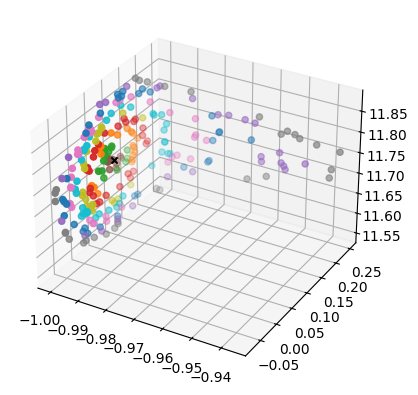

In [147]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


labels = mat.squeeze(0).cpu().numpy()
for i in range(labels.shape[0]):
    clus_ps = mat_pts[np.where(labels==i)[0],:]
    ax.scatter(clus_ps[:,0], clus_ps[:,1], clus_ps[:,2], marker='o')
ax.scatter(all_pts[0][0][0], all_pts[0][0][1], all_pts[0][0][2], marker='x', c='black')

plt.show()

In [163]:
#checking cdist function
from scipy.spatial.distance import cdist
a = torch.tensor([[1,2,3],[4,5,6], [7,8,9]], dtype=torch.float64)
# a = all_pts[0]
print(a.dtype)
print(torch.cdist(a, a))
d = torch.cdist(a, a)

torch.float64
tensor([[ 0.0000,  5.1962, 10.3923],
        [ 5.1962,  0.0000,  5.1962],
        [10.3923,  5.1962,  0.0000]], dtype=torch.float64)


In [227]:
import torch
from torch_cluster import knn

def find_knn(points_list, k=3):
    # Convert the list of 3D points to a PyTorch tensor
    points_tensor = torch.tensor(points_list).float()
    print(points_tensor)
    # Transpose the input points to match the expected shape by knn
    points_tensor = points_tensor.transpose(0, 1).contiguous()

    # Use knn to find k-nearest neighbors
    indices = knn(points_tensor, points_tensor, k=k)

    return indices

# Example usage
points_list = [
    [1.0, 2.0, 3.0],
    [4.0, 5.0, 6.0],
    [7.0, 8.0, 9.0],
    # Add more points as needed
]

points_list = torch.tensor(all_pts[0])
print(points_list.shape)
k = 250
points_list = torch.tensor(points_list).float()
_,nearest_indices = knn(points_list, points_list, k)
print(nearest_indices)


torch.Size([100000, 3])


/tmp/ipykernel_155082/3850879409.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points_list = torch.tensor(points_list).float()


tensor([    0, 41263, 80395,  ..., 18049, 77117, 75568])


In [228]:
points_list = torch.tensor(all_pts[0])
print(points_list.shape)
k = 250
points_list = torch.tensor(points_list).float()
nearest_indices = knn(points_list, points_list, k)
print(nearest_indices)

torch.Size([100000, 3])


/tmp/ipykernel_155082/1143905144.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points_list = torch.tensor(points_list).float()


tensor([[    0,     0,     0,  ..., 99999, 99999, 99999],
        [    0, 41263, 80395,  ..., 18049, 77117, 75568]])


In [208]:
y = points_list[nearest_indices[0]] # y


In [209]:
x = points_list[nearest_indices[1]] # x

In [210]:
d = torch.linalg.norm(x-y, dim=1)
d

tensor([0.0000, 0.0045, 0.0154,  ..., 0.1674, 0.1676, 0.1677])

In [216]:
d = d.reshape(-1,250)

In [217]:
d.shape

torch.Size([100000, 250])

In [218]:
d

tensor([[0.0000, 0.0045, 0.0154,  ..., 0.1700, 0.1707, 0.1710],
        [0.0000, 0.0057, 0.0084,  ..., 0.1679, 0.1679, 0.1696],
        [0.0000, 0.0099, 0.0103,  ..., 0.1808, 0.1809, 0.1819],
        ...,
        [0.0000, 0.0129, 0.0132,  ..., 0.1804, 0.1807, 0.1807],
        [0.0000, 0.0022, 0.0058,  ..., 0.1766, 0.1766, 0.1770],
        [0.0000, 0.0064, 0.0090,  ..., 0.1674, 0.1676, 0.1677]])

In [219]:
nearest_indices.shape

torch.Size([2, 25000000])

In [223]:
i = nearest_indices[1].reshape(-1,250)
i

tensor([[    0, 41263, 80395,  ..., 82976, 73012, 62778],
        [    1,  3418, 83479,  ..., 64957, 39156, 10338],
        [    2, 71764, 96298,  ..., 57339, 24104, 51253],
        ...,
        [99997, 32263, 46031,  ..., 12416, 48691, 67251],
        [99998, 32976, 90715,  ..., 66461, 72973, 14037],
        [99999, 98423, 67891,  ..., 18049, 77117, 75568]])

In [225]:
i = i[:,1:]

In [226]:
i

tensor([[41263, 80395, 25088,  ..., 82976, 73012, 62778],
        [ 3418, 83479, 52232,  ..., 64957, 39156, 10338],
        [71764, 96298, 44155,  ..., 57339, 24104, 51253],
        ...,
        [32263, 46031, 52627,  ..., 12416, 48691, 67251],
        [32976, 90715, 69411,  ..., 66461, 72973, 14037],
        [98423, 67891, 72500,  ..., 18049, 77117, 75568]])

In [4]:
import torch
from torch_cluster import knn

def find_neighs_torch(points, k=250):
    points = torch.from_numpy(points).cuda()
    all_indices = knn(points, points, k=k).cuda()
    y = points[all_indices[0]]
    x = points[all_indices[1]]
    dists = torch.linalg.norm(y-x, dim=1)
    dists = dists.reshape(-1,250)
    indices = all_indices[1].reshape(-1,250)
    dists = dists.cpu().numpy()
    indices = indices.cpu().numpy()
    return dists[:,1:], indices[:,1:]

In [5]:
find_neighs_torch(all_pts[0])

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/home/cvig_5/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torch_cluster/knn.py", line 72, in knn
        ptr_y = torch.bucketize(arange, batch_y)

    return torch.ops.torch_cluster.knn(x, y, ptr_x, ptr_y, k, cosine,
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
                                       num_workers)
RuntimeError: k <= 100 INTERNAL ASSERT FAILED at "csrc/cuda/knn_cuda.cu":98, please report a bug to PyTorch. `k` needs to smaller than or equal to 100


In [6]:
import torch
from torch_cluster import knn

def find_neighs_torch(points, k=250):
    points = torch.from_numpy(points)
    all_indices = knn(points, points, k=k)
    y = points[all_indices[0]]
    x = points[all_indices[1]]
    dists = torch.linalg.norm(y-x, dim=1)
    dists = dists.reshape(-1,250)
    indices = all_indices[1].reshape(-1,250)
    # dists = dists.cpu().numpy()
    # indices = indices.cpu().numpy()
    return dists[:,1:], indices[:,1:]

In [7]:
find_neighs_torch(all_pts[0])

(tensor([[0.0045, 0.0154, 0.0185,  ..., 0.1700, 0.1707, 0.1710],
         [0.0057, 0.0084, 0.0114,  ..., 0.1679, 0.1679, 0.1696],
         [0.0099, 0.0103, 0.0253,  ..., 0.1808, 0.1809, 0.1819],
         ...,
         [0.0130, 0.0132, 0.0160,  ..., 0.1804, 0.1807, 0.1807],
         [0.0022, 0.0058, 0.0132,  ..., 0.1766, 0.1766, 0.1770],
         [0.0064, 0.0090, 0.0175,  ..., 0.1674, 0.1676, 0.1677]],
        dtype=torch.float64),
 tensor([[41263, 80395, 25088,  ..., 82976, 73012, 62778],
         [ 3418, 83479, 52232,  ..., 64957, 39156, 10338],
         [71764, 96298, 44155,  ..., 57339, 24104, 51253],
         ...,
         [32263, 46031, 52627,  ..., 12416, 48691, 67251],
         [32976, 90715, 69411,  ..., 66461, 72973, 14037],
         [98423, 67891, 72500,  ..., 18049, 77117, 75568]]))

In [ ]:
# checking the benefits of parallel and delayed func

def process_one_pcd(main_ind, point_ind=0):
    all_pts = np.load("xyz_points.npy")
    all_norms = np.load("init_normals.npy")
    pts = all_pts[main_ind]
    norms = all_norms[main_ind]
    print("in process_pcd:", pts.shape, norms.shape, main_ind, point_ind)
    para_ans = Parallel(n_jobs=-1)(delayed(find_neighs_torch)(pts))
    return para_ans
    # neighs = pts[indices_ori]
    # # labels_per_row = np.apply_along_axis(lambda row: ckwrap.ckmeans(row, 5).labels, 1, dists_ori)
    # # dists_ori = torch.from_numpy(dists_ori).cuda()
    # dist_pts = dists_ori[point_ind]
    # labels_per_row = torch_kmeans(dist_pts, 10) # shape: (1, 249)

    # # print(labels_per_row.device) #this is on cuda:0
    # # return labels_per_row, neighs[0]

    # # print(f'using %d gpus: ', torch.cuda.device_count())
   
    # pts = torch.from_numpy(pts).cuda()
    # norms = torch.from_numpy(norms).cuda()
    # # indices_ori = torch.from_numpy(indices_ori).cuda()
    # # labels_per_row = torch.from_numpy(labels_per_row).cuda()

    # i = point_ind
    # ind = indices_ori[i]
    # labels = labels_per_row.squeeze(0)
    # # print(labels.shape)
    # # for i,( ind, labels) in enumerate(zip(indices_ori, labels_per_row)):
    # center = pts[i]
    # mat = []
    # for clus in torch.unique(labels, dim=0):
    #     # ind_clus = ind[np.where(labels == clus)]
    #     ind_clus = ind[torch.where(labels==clus)]
    #     coords = pts[ind_clus]

    #     if(coords.shape[0] < 25):
    #         # 2 random integers
    #         for _ in range(25-(coords.shape[0])):
    #             a, b = torch.randint(1, coords.shape[0], (2,))
    #             a_n, b_n = torch.divide(a, (a+b)), torch.divide(b, (a+b))
    #             rnd_pt = torch.add(torch.multiply(a_n, (center-coords[a])), torch.multiply(b_n, (center-coords[b]))).unsqueeze(0)
    #             coords = torch.cat((coords, rnd_pt), dim=0)
    #     else:
    #         coords = coords[:25]
        
    #     # print("coords after adding random points: ", coords)

        
    #     vec2 = torch.subtract(center, coords)
    #     closest_ind = torch.argmin(torch.linalg.norm(vec2, dim=1))
    #     closest = coords[closest_ind]
    #     vec1 = torch.subtract(center, closest)
    #     vec2 = torch.cat((vec2[:closest_ind], vec2[closest_ind+1:]), dim=0)
    #     vec1 = torch.divide(vec1, torch.linalg.norm(vec1))
    #     vec2 = torch.divide(vec2, torch.linalg.norm(vec2, dim=1, keepdim=True))
    #     crs_pdts = torch.cross(vec1.expand_as(vec2), vec2)
    #     area = torch.linalg.norm(crs_pdts, dim=1)
    #     crs_pdts = torch.divide(crs_pdts, torch.linalg.norm(crs_pdts, dim=1, keepdim=True))
    #     dot_pdts = torch.tensordot(crs_pdts, norms[i].T, dims=1)
    #     # print(dot_pdts)
    #     sign = torch.divide(dot_pdts, torch.abs(dot_pdts))
    #     area = torch.multiply(area, sign)
    #     sort_indices = torch.argsort(area)
    #     sorted_coords = coords[sort_indices]
        
    #     # return dot_pdts, area, crs_pdts, coords, sorted_coords, vec1, vec2, sign, closest, center, closest_ind
        
    #     mat.append(sorted_coords)
    #     # print("device of mat: ", mat[-1].device)
    # mat = np.array([tensor.cpu().numpy() for tensor in mat])

    # return mat